# 2.three dims models reconstruction

This notebook demonstrates the process of 3D models reconstruction based on 3D spatial transcriptome data. This is done in the following four steps.

1. Construct the original 3D point cloud model;
2. Construct the mesh model based on the 3D point cloud model;
3. Construct the voxel model based on the mesh model;
4. Save the models.

This example reconstructs 3D Drosophila embryos model based on 3D spatial transcriptome data of Drosophila embryos.

## Packages

In [1]:
import os
import sys

import numpy as np

sys.path.insert(0, "/home/yao/PythonProject/Test_packages/dynamo-release")
sys.path.insert(0, "/home/yao/PythonProject/Yao_packages/spateo-release")
import dynamo as dyn
import spateo as st

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/home/yao/.local/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spaghetti/network.py:36: Future

## Data source

In [2]:
adata = st.read_h5ad("E7-9h_cellbin_tdr_v2.h5ad")
adata

AnnData object with n_obs × n_vars = 25857 × 8136
    obs: 'area', 'slices', 'nGenes', 'nCounts', 'pMito', 'nMito', 'pass_basic_filter', 'scc', 'auto_anno', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage'
    uns: 'PCs', '__type', 'auto_anno_result', 'dendrogram_anno_cell_type', 'dendrogram_anno_germ_layer', 'dendrogram_anno_tissue', 'explained_variance_ratio_', 'latter_models_align', 'neighbors', 'pca_mean', 'pca_valid_ind', 'pearson_X_neighbors', 'rank_genes_groups', 'rank_genes_groups_anno_cell_type', 'rank_genes_groups_anno_germ_layer', 'rank_genes_groups_anno_tissue', 'scc', 'spatial'
    obsm: '3d_align_spatial', 'align_spatial', 'bbox', 'before_3d_align_spatial', 'contour', 'pearson_X_pca', 'pearson_X_umap', 'spatial', 'tdr_spatial'
    layers: 'counts_X', 'log1p_X', 'pearson_X', 'spliced', 'unspliced'

## 3D reconstruction of original point cloud model

In [3]:
tissue_colormap = {
    "CNS": "#5A2686",
    "midgut": "#DC143C",
    "amnioserosa": "#FFDD00",
    "salivary gland": "#FFA500",

    "epidermis": "#ADD8E6",
    "muscle": "#1AAB27",
    "trachea": "#7F90F0",
    "hemolymph": "#CD5C5C",
    "yolk": "#8B0000",
}
embryo_pc = st.tdr.construct_pc(
    adata=adata.copy(),
    spatial_key="3d_align_spatial",
    groupby="anno_tissue",
    key_added="tissue",
    colormap=tissue_colormap,
)
embryo_pc.point_data

pyvista DataSetAttributes
Association     : POINT
Active Scalars  : tissue_rgba
Active Vectors  : None
Active Texture  : None
Active Normals  : None
Contains arrays :
    tissue_rgba             float32    (25857, 4)           SCALARS
    tissue                  <U14       (25857,)
    obs_index               <U16       (25857,)

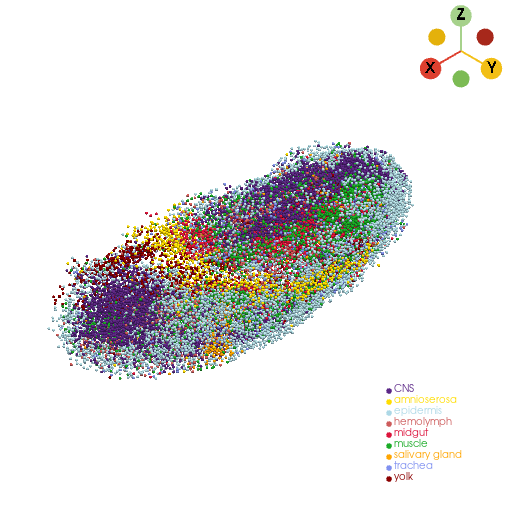

In [4]:
st.pl.three_d_plot(
    model=embryo_pc,
    key="tissue",
    model_style="points",
    model_size=3,
    jupyter="static",
    window_size=(512, 512)
)

## 3D reconstruction of mesh model

In [6]:
embryo_mesh, _ = st.tdr.construct_surface(
    pc=embryo_pc,
    key_added="tissue",
    label="embryo_shell",
    color="gainsboro",
    alpha=0.6,
    cs_method="marching_cube",
    cs_args={"mc_scale_factor": 1.},
    smooth=5000,
    scale_factor=1.02,
)
embryo_mesh.cell_data

pyvista DataSetAttributes
Association     : CELL
Active Scalars  : tissue_rgba
Active Vectors  : None
Active Texture  : None
Active Normals  : None
Contains arrays :
    vtkOriginalCellIds      int64      (39994,)
    tissue_rgba             float32    (39994, 4)           SCALARS
    tissue                  <U12       (39994,)

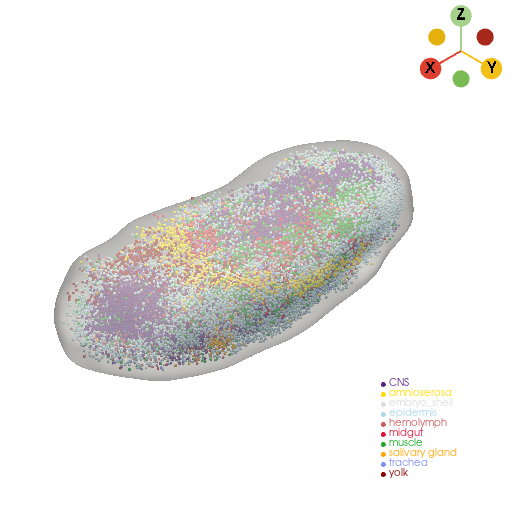

In [7]:
st.pl.three_d_plot(
    model=st.tdr.collect_models([embryo_mesh, embryo_pc]),
    key="tissue",
    model_style=["surface", "points"],
    model_size=3,
    jupyter="static",
)

## 3D reconstruction of cell mesh model

In [9]:
# Add cell radius info
obs_index = embryo_pc.point_data["obs_index"].tolist()
area = adata[obs_index, :].obs["area"].values
cell_radius = pow(np.asarray(area), 1 / 2)
st.tdr.add_model_labels(model=embryo_pc, labels=cell_radius, key_added="cell_radius", where="point_data", colormap="hot_r", inplace=True)
embryo_cells = st.tdr.construct_cells(pc=embryo_pc, cell_size=embryo_pc.point_data["cell_radius"], geometry="sphere", factor=0.2)
embryo_cells.point_data

pyvista DataSetAttributes
Association     : POINT
Active Scalars  : cell_centroid
Active Vectors  : None
Active Texture  : None
Active Normals  : Normals
Contains arrays :
    tissue_rgba             float32    (21771594, 4)
    tissue                  <U14       (21771594,)
    obs_index               <U16       (21771594,)
    cell_radius             float64    (21771594,)
    cell_size               float32    (21771594,)
    Normals                 float32    (21771594, 3)        NORMALS
    cell_centroid           float64    (21771594, 3)        SCALARS

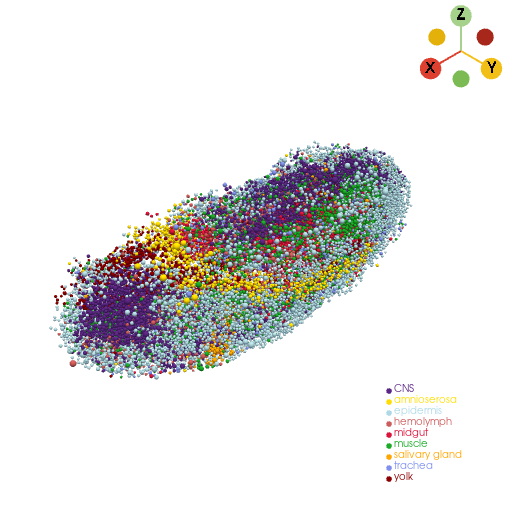

In [10]:
st.pl.three_d_plot(model=embryo_cells, key="tissue", model_style="surface", jupyter="static", window_size=(512, 512))

## 3D reconstruction of voxel model

In [11]:
embryo_voxel = st.tdr.voxelize_mesh(mesh=embryo_mesh, voxel_pc=None, key_added="tissue", label="embryo_voxel", color="gainsboro", smooth=500)

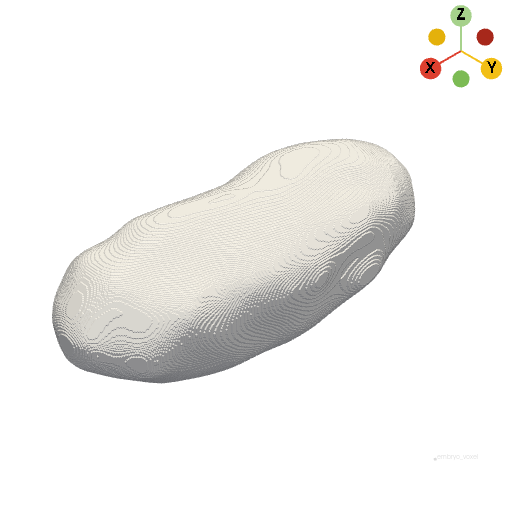

In [12]:
st.pl.three_d_plot(model=embryo_voxel, key="tissue", model_style="surface", jupyter="static", window_size=(512, 512))

## save models

In [35]:
st.tdr.save_model(model=embryo_pc, filename="embryo_pc_model.vtk")
st.tdr.save_model(model=embryo_mesh, filename="embryo_mesh_model.vtk")
st.tdr.save_model(model=embryo_cells, filename="embryo_cells_mesh_model.vtk")
st.tdr.save_model(model=embryo_voxel, filename="embryo_voxel_model.vtk")